In [1]:
# Import of all necessary packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import length, when
import pyspark.sql.functions as F
import requests
from bs4 import BeautifulSoup # https://www.crummy.com/software/BeautifulSoup/bs4/doc/
import pandas as pd
from pyspark.sql.types import IntegerType, DoubleType
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
import re
from datetime import datetime
import tabula #https://pypi.org/project/tabula-py/

In [2]:
# Instantiate SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName('Milestone I Project') \
    .getOrCreate()
sc = spark.sparkContext

In [3]:
# Yelp COVID-19 addendum dataset loaded to Spark DataFrame https://www.yelp.com/dataset/download
COVID = spark.read.json('COVID_sample.json')
#COVID.limit(100).write.format('json').option('header',True).mode('overwrite').save('COVID_sample.json')

In [4]:
# Binarize closure data for count aggregation
COVID = \
COVID.withColumn("temp_closed", \
                                    when(COVID["Temporary Closed Until"] == \
                                         "FALSE", 0).otherwise(1))

In [5]:
# rename column to enable greedy SQL SELECT
COVID = COVID.withColumnRenamed("business_id","COVID_business_id")

In [6]:
# use length of COVID-19 highlights column as a relative standardized score of special services
COVID = \
COVID.withColumn("COVIDhighlights", \
                                    when(COVID["highlights"] == \
                                         "FALSE", 0).otherwise(length(COVID["highlights"])))

In [7]:
COVID.createOrReplaceTempView("COVID")

In [8]:
# Yelp Open dataset business subset loaded to Spark DataFrame https://www.yelp.com/dataset/download
business = spark.read.json('business_sample.json')
business.createOrReplaceTempView("business")
#business.limit(100).write.format('json').option('header',True).mode('overwrite').save('business_sample.json')

In [9]:
# Filter to 7 main states represented by each metropolitan area
business = \
spark.sql("SELECT * FROM business WHERE state IN ('AZ', 'NV', 'WI', 'NC', 'IL', 'OH', 'PA')")

In [10]:
# create dummy variables of categories and subcategories for filtering and aggregation functions
business = business.withColumn('home_garden', (F.instr(business.categories, 'Home & Garden')>0).cast('int'))
business = business.withColumn('cannabis', (F.instr(business.categories, 'Cannabis')>0).cast('int'))
business = business.withColumn('head_shops', (F.instr(business.categories, 'Head Shops')>0).cast('int'))
business = business.withColumn('tobacco_shops', (F.instr(business.categories, 'Tobacco Shops')>0).cast('int'))
business = business.withColumn('wholesale_stores', (F.instr(business.categories, 'Wholesale Stores')>0).cast('int'))
business = business.withColumn('grocery', (F.instr(business.categories, 'Grocery')>0).cast('int'))
business = business.withColumn('drug_stores', (F.instr(business.categories, 'Drugstores')>0).cast('int'))
business = business.withColumn('shopping_centers', (F.instr(business.categories, 'Shopping Centers')>0).cast('int'))
business = business.withColumn('nightlife', (F.instr(business.categories, 'Nightlife')>0).cast('int'))
business = business.withColumn('beer_wine_spirits', (F.instr(business.categories, 'Beer, Wine & Spirits')>0).cast('int'))
business = business.withColumn('fondue', (F.instr(business.categories, 'Fondue')>0).cast('int'))
business = business.withColumn('tapas', (F.instr(business.categories, 'Tapas')>0).cast('int'))
business = business.withColumn('hot_pot', (F.instr(business.categories, 'Hot Pot')>0).cast('int'))
business = business.withColumn('buffets', (F.instr(business.categories, 'Buffets')>0).cast('int'))
business = business.withColumn('pizza', (F.instr(business.categories, 'Pizz')>0).cast('int'))
business = business.withColumn('chinese', (F.instr(business.categories, 'Chinese')>0).cast('int'))
business = business.withColumn('fast_food', (F.instr(business.categories, 'Fast Food')>0).cast('int'))
business = business.withColumn('shopping', (F.instr(business.categories, 'Shopping')>0).cast('int'))
business = business.withColumn('restaurants', (F.instr(business.categories, 'Restaurants')>0).cast('int'))
business = business.withColumn('beauty_spas', (F.instr(business.categories, 'Beauty & Spas')>0).cast('int'))
business = business.withColumn('fitness', (F.instr(business.categories, 'Fitness & Instruction')>0).cast('int'))
business = business.withColumn('mountain_biking', (F.instr(business.categories, 'Mountain Biking')>0).cast('int'))
business = business.withColumn('lakes', (F.instr(business.categories, 'Lakes')>0).cast('int'))
business = business.withColumn('golf', (F.instr(business.categories, 'Golf')>0).cast('int'))
business = business.withColumn('hiking', (F.instr(business.categories, 'Hiking')>0).cast('int'))
business = business.withColumn('mini_golf', (F.instr(business.categories, 'Mini Golf')>0).cast('int'))
business = business.withColumn('amusement_parks', (F.instr(business.categories, 'Amusement Parks')>0).cast('int'))
business = business.withColumn('horseback_riding', (F.instr(business.categories, 'Horseback Riding')>0).cast('int'))
business = business.withColumn('parks', (F.instr(business.categories, 'Parks')>0).cast('int'))
business = business.withColumn('escape_games', (F.instr(business.categories, 'Escape Games')>0).cast('int'))
business = business.withColumn('go_karts', (F.instr(business.categories, 'Go Karts')>0).cast('int'))
business = business.withColumn('axe_throwing', (F.instr(business.categories, 'Axe Throwing')>0).cast('int'))
business = business.withColumn('bowling', (F.instr(business.categories, 'Bowling')>0).cast('int'))
business = business.withColumn('bike_rentals', (F.instr(business.categories, 'Bike Rentals')>0).cast('int'))
business = business.withColumn('hiking', (F.instr(business.categories, 'Hiking')>0).cast('int'))
#things done in the city by self outdoors on land

In [11]:
business.createOrReplaceTempView("business")

In [12]:
# Yelp Open dataset business subset and COVID-19 addendum joined
bus_COVID = \
spark.sql("SELECT * FROM business LEFT JOIN COVID ON business.business_id = COVID.COVID_business_id")

In [13]:
bus_COVID.createOrReplaceTempView("bus_COVID")

In [14]:
# Use BeautifulSoup package to scrape table of state public health actions from Wikipedia
# calculate timedeltas between various public health policy actions for use as ordinal variables in
# correlation analysis or regression analysis
res = requests.get("https://en.wikipedia.org/wiki/U.S._state_and_local_government_responses_to_the_COVID-19_pandemic")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')
state_order = pd.read_html(str(table), header=1)
state_orders = state_order[0]
def remove_attrib(row):
    return re.sub('\(.*?\)', '', row)
state_orders['Stay at home ordered'] = state_orders['Stay at home ordered'].apply(lambda x: remove_attrib(x))
state_orders['State of emergency declared'] = \
state_orders['State of emergency declared'].apply(lambda x: datetime.strptime(x + " 2020", "%B %d %Y"))
state_orders['Stay at home ordered'] = \
state_orders['Stay at home ordered'].apply(lambda x: datetime.strptime(x + " 2020", "%B %d %Y") if any(char.isdigit() for char in x) else pd.NaT)
state_orders['emergency_to_home_days'] = state_orders['Stay at home ordered'] - state_orders['State of emergency declared']
state_orders['emergency_to_home_days'] = state_orders['emergency_to_home_days'].apply(lambda x: x.days)
state_orders['emergency_from_mean'] = state_orders['State of emergency declared'].mean() - state_orders['State of emergency declared']
state_orders['emergency_from_mean'] = state_orders['emergency_from_mean'].apply(lambda x: x.days)
state_orders['stay_from_mean'] = state_orders['Stay at home ordered'].mean() - state_orders['Stay at home ordered']
state_orders['stay_from_mean'] = state_orders['stay_from_mean'].apply(lambda x: x.days)

In [15]:
# creation of state public health orders Spark DataFrame
state_orders = spark.createDataFrame(state_orders)
state_orders = state_orders.withColumnRenamed("State/territory","stateorterritory")
state_orders.createOrReplaceTempView("state_orders")

In [16]:
# create dummy variables for filtering and aggregation functions on face covering and out-of-state quarantine
# policies
state_orders = \
state_orders.withColumn("facecover", \
                                    when(state_orders["Face coverings required in public[5]"] == \
                                         "Yes", 1).otherwise(0))
state_orders = \
state_orders.withColumn("oos_quarantine", \
                                    when(state_orders["Out-of-state travel restrictions"] == \
                                         "No", 0).otherwise(1))

In [17]:
state_orders.createOrReplaceTempView("state_orders")

In [18]:
# read text data from US Census to create a Spark DataFrame to join on state with flexibility for full state
# name or 2-letter state abbreviation
stateabbrev = pd.read_table('https://www2.census.gov/geo/docs/reference/state.txt', 
                            delimiter = '|').drop(columns = ['STATE', 'STATENS'])
stateabbrev = spark.createDataFrame(stateabbrev)
stateabbrev.createOrReplaceTempView("stateabbrev")

In [19]:
# join state public health policy data with Census state name/abbreviation data to prepare for joining with
# Yelp business and COVID-19 data
state_orders = \
spark.sql("SELECT * FROM state_orders LEFT JOIN stateabbrev ON state_orders.stateorterritory = stateabbrev.STATE_NAME")

In [20]:
state_orders.createOrReplaceTempView("state_orders")

In [21]:
# subset state orders database to drop columns not needed
state_orders = spark.sql("SELECT stateorterritory, emergency_to_home_days, emergency_from_mean, stay_from_mean, STUSAB, facecover, oos_quarantine FROM state_orders")

In [22]:
state_orders.createOrReplaceTempView("state_orders")

In [23]:
# join state public health policy orders with Yelp business and COVID-19 data
bus_COVID_orders = \
spark.sql("SELECT * FROM bus_COVID LEFT JOIN state_orders ON bus_COVID.state = state_orders.STUSAB")


In [24]:
bus_COVID_orders.createOrReplaceTempView("bus_COVID_orders")

In [25]:
# Sentiment Analysis scored Tweets for polarity aggregated by date read into pySpark DataFrame
# See "Tweet Text Sentiment Analysis" notebook for details on creation of this dataset
sentiment = spark.read.csv("Tweet_Text_Sentiment_data_average.csv", header = True)
sentiment.createOrReplaceTempView("sentiment")

In [26]:
# Sentiment data joined wtih state public health policy data and Yelp business and COVID-19 data
bus_COVID_orders_sent = \
spark.sql("SELECT * FROM bus_COVID_orders LEFT JOIN sentiment ON bus_COVID_orders.state = sentiment.sentiment_State")

In [27]:
bus_COVID_orders_sent.createOrReplaceTempView("bus_COVID_orders_sent")

In [28]:
# Use tabula package to scrape Small Business Administration-reported Paycheck Protection Program loan
# data from online PDF file, read into pySpark DataFrame, cleaned
#sbappp = tabula.read_pdf('https://www.sba.gov/sites/default/files/2020-08/PPP_Report_Public%20-%202020-08-01-508.pdf', pages='5')
#sbapppcols = sbappp[0]
sbapppcols = pd.read_csv('sbappptable.csv')
sbapppcol1 = sbapppcols[['State','Loan Count','Net Dollars']]
sbapppcol2 = sbapppcols[['Unnamed: 0','Loan Count.1','Net Dollars.1']]
sbapppcol2 = sbapppcol2.rename(columns = {"Unnamed: 0": "State", "Loan Count.1": "Loan Count", "Net Dollars.1": "Net Dollars"})
sbapppcol3 = sbapppcols[['Unnamed: 1','Loan Count.2','Net Dollars.2']]
sbapppcol3 = sbapppcol3.rename(columns = {"Unnamed: 1": "State", "Loan Count.2": "Loan Count", "Net Dollars.2": "Net Dollars"})
sbapppus = pd.concat([sbapppcol1, sbapppcol2, sbapppcol3], ignore_index=True)
sbapppus['Loan Count'] = sbapppus['Loan Count'].str.replace(',', '')
sbapppus['Net Dollars'] = sbapppus['Net Dollars'].str.replace('$', '')
sbapppus['Net Dollars'] = sbapppus['Net Dollars'].str.replace(',', '')
sbapppus['Loan Count'] = pd.to_numeric(sbapppus['Loan Count'])
sbapppus['Net Dollars'] = pd.to_numeric(sbapppus['Net Dollars'])

In [29]:
# convert web-scraped data to string type to avoid errors during pySpark DataFrame creation
sbapppus[['State', 'Loan Count', 'Net Dollars']] = sbapppus[['State', 'Loan Count', 'Net Dollars']].astype(str)
sbappp = spark.createDataFrame(sbapppus)
sbappp.createOrReplaceTempView("sbappp")
sbappp = sbappp.withColumnRenamed("State","sbappp_State")
sbappp.createOrReplaceTempView("sbappp")

In [30]:
#PPP dataset joined with cummulative master DataFrame
bus_COVID_orders_sent = \
spark.sql("SELECT * FROM bus_COVID_orders_sent LEFT JOIN sbappp ON bus_COVID_orders_sent.state = sbappp.sbappp_State")


In [31]:
bus_COVID_orders_sent.createOrReplaceTempView("bus_COVID_orders_sent")

In [32]:
# cast web-scraped text data to numerical types
bus_COVID_orders_sent = bus_COVID_orders_sent.withColumn("Loan Count", bus_COVID_orders_sent["Loan Count"].cast(IntegerType()))
bus_COVID_orders_sent = bus_COVID_orders_sent.withColumn("Net Dollars", bus_COVID_orders_sent["Net Dollars"].cast(DoubleType()))
bus_COVID_orders_sent.createOrReplaceTempView("bus_COVID_orders_sent")

In [33]:
#SQL query to group data by state and perform aggregate counts and means of data
groupby_state_query = """
SELECT state, count(state) as business_count, sum(COVIDhighlights) as COVIDhighlights, sum(COVIDhighlights)/count(state) as COVIDhighlightspercap, sum(temp_closed)/count(state) as pct_temp_closed, mean(latitude) as latitude_mean, mean(longitude) as longitude_mean, emergency_to_home_days, emergency_from_mean, stay_from_mean, mean(Average_polarity) as polarity_mean, mean(Average_subjectivity) as subjectivity_mean, `Loan Count`, `Net Dollars`, facecover, oos_quarantine
FROM bus_COVID_orders_sent
GROUP BY state, emergency_to_home_days, emergency_from_mean, stay_from_mean, `Loan Count`, `Net Dollars`, facecover, oos_quarantine
"""
bus_COVID_groupby_state = spark.sql(groupby_state_query)

In [34]:
# collect grouped data (by State) from pySpark DataFrame in a Pandas DataFrame
# add DataFrame column for state political leaning
# per https://en.wikipedia.org/wiki/Red_states_and_blue_states 2016 presidential election:
# -2 for states with Republican win over 5%, -1 for states with Republican win under 5%
# +2 for states with Democratic win over 5%, +1 for states with Democratic win over 5%
# to establish classes for correlation and possible regression analysis
bus_COVID_groupby_state_pd = bus_COVID_groupby_state.toPandas()
bus_COVID_groupby_state_pd['political'] = [-1, 1, -1, -1, 2, -2, -1]

In [35]:
def calculate_pvalues(df):
    '''p-value DataFrame mask calculator for correlation matrix'''
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns = df.columns)
    p_values = dfcols.transpose().join(dfcols, how = 'outer')
    for row in df.columns:
        for col in df.columns:
            value = stats.pointbiserialr(df[row], df[col])
            p_values[row][col] = round(value[1], 2)
    return p_values

def calculate_corr(df):
    '''correlation coefficient DataFrame mask calculator for correlation matrix'''
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns = df.columns)
    coeff = dfcols.transpose().join(dfcols, how = 'outer')
    for row in df.columns:
        for col in df.columns:
            value = stats.pointbiserialr(df[row], df[col])
            coeff[row][col] = round(value[0], 2)
    return coeff

In [36]:
# set GLOBAL viz style
sns.set(font_scale = 1.3, style = "white")

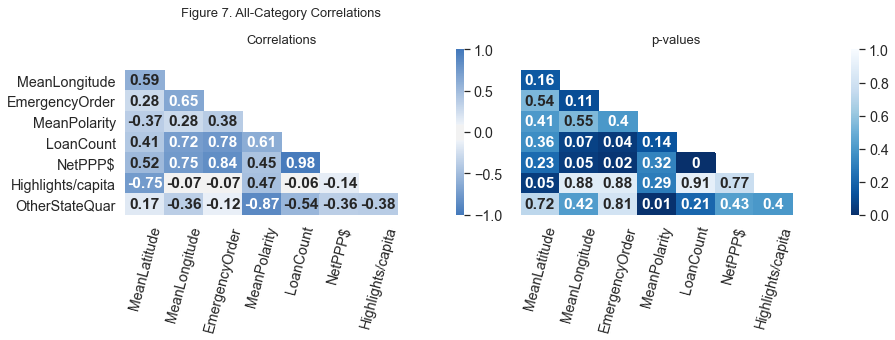

In [37]:
bus_COVID_groupby_state_pd = pd.read_csv('bus_COVID_groupby_state_pd.csv')
# Figure 7 - All-Category Correlations
df_corr = bus_COVID_groupby_state_pd[['latitude_mean', 'longitude_mean', 'emergency_from_mean', 'polarity_mean', 
                                      'Loan Count', 'Net Dollars', 'COVIDhighlightspercap', 'oos_quarantine']]
xticks = ticks = np.array(['MeanLatitude', 'MeanLongitude', 'EmergencyOrder', 'MeanPolarity', 'LoanCount', 'NetPPP$',
                           'Highlights/capita', '     '])
yticks = ticks = np.array(['     ', 'MeanLongitude', 'EmergencyOrder', 'MeanPolarity', 'LoanCount', 'NetPPP$',
                           'Highlights/capita', 'OtherStateQuar'])
fig,ax = plt.subplots(figsize = (13, 5))
cmap = sns.diverging_palette(250, 250, sep=25, as_cmap=True)

plt.subplot(1, 2, 1)
correlations = calculate_corr(df_corr).astype(float)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, mask = mask, annot = True, vmin = -1, vmax = 1, cmap = cmap, xticklabels = xticks,
            yticklabels = yticks, annot_kws = {"fontweight": 'bold'})
plt.title('Figure 7. All-Category Correlations\n\nCorrelations', fontsize = 13)
plt.xticks(rotation = 75)
plt.tight_layout()

plt.subplot(1, 2, 2)
pvalues = calculate_pvalues(df_corr).astype(float)
mask = np.zeros_like(pvalues)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pvalues, mask = mask, annot = True, vmin = 0, vmax = 1, cmap = "Blues_r", xticklabels = xticks,
            yticklabels = '', annot_kws = {"fontweight": 'bold'})
plt.title('p-values', fontsize = 13)
plt.xticks(rotation = 75)
plt.tight_layout()

plt.savefig('overall.png', format = 'png')

In [38]:
# create dummy variables for filtering
bus_COVID_orders_sent.withColumn('shopping', (F.instr(bus_COVID_orders_sent.categories, 'Shopping')>0).cast('int'))
bus_COVID_orders_sent.withColumn('restaurants', (F.instr(bus_COVID_orders_sent.categories, 'Restaurants')>0).cast('int'))
bus_COVID_orders_sent.withColumn('beauty_spas', (F.instr(bus_COVID_orders_sent.categories, 'Beauty & Spas')>0).cast('int'))
bus_COVID_orders_sent.withColumn('fitness', (F.instr(bus_COVID_orders_sent.categories, 'Fitness & Instruction')>0).cast('int'))

DataFrame[address: string, attributes: struct<AcceptsInsurance:string,Alcohol:string,Ambience:string,BYOB:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>, business_id: string, categories: string, city: string, hours: struct<Friday:string,Monday:string,Saturday:string,Sunday:string,Thursday:string,Tuesday:string,Wednesday:string>, is_open: bigint, latitude: double, longitude: double, name: string,

In [39]:
# subset master DataFrame to create Category DataFrames
shopping = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE shopping == 1")
restaurants = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE restaurants == 1")
beauty_spas = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE beauty_spas == 1")
fitness = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE fitness == 1")

In [40]:
shopping.createOrReplaceTempView("shopping")
restaurants.createOrReplaceTempView("restaurants")
beauty_spas.createOrReplaceTempView("beauty_spas")
fitness.createOrReplaceTempView("fitness")

In [41]:
# use SQL SELECT statements to count closed businesses in each category, total businesses in each category
# to calculate percentage of businesses listed as Closed on Yelp for each category
shoppingpctclosed = ((spark.sql("SELECT * FROM shopping WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM shopping WHERE is_open == 0").count())/shopping.count())*100
restaurantspctclosed = ((spark.sql("SELECT * FROM restaurants WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM restaurants WHERE is_open == 0").count())/restaurants.count())*100
beauty_spaspctclosed = ((spark.sql("SELECT * FROM beauty_spas WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM beauty_spas WHERE is_open == 0").count())/beauty_spas.count())*100
fitness_instructionpctclosed = ((spark.sql("SELECT * FROM fitness WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM fitness WHERE is_open == 0").count())/fitness.count())*100

In [42]:
# create Pandas DataFrame of category closure data for visualization
sectorbarchartdf = pd.DataFrame()
sectorbarchartdf['sector'] = ['Shopping', 'Restaurants', 'Beauty\n& Spas', 'Fitness']
sectorbarchartdf['percentclosed'] = [shoppingpctclosed, restaurantspctclosed, beauty_spaspctclosed, fitness_instructionpctclosed]
sectorbarchartdf = sectorbarchartdf.sort_values(by = ['percentclosed'])

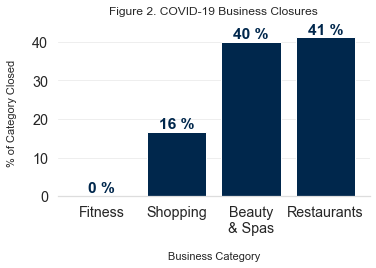

In [43]:
# Figure 2 - COVID-19 Business Closure Percentages by Category
fig, ax = plt.subplots(figsize = (5.5, 4))

bars = ax.bar(x = sectorbarchartdf.sector, height = sectorbarchartdf.percentclosed, 
              tick_label = sectorbarchartdf.sector, color = '#00274C')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom = False, left = False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color = '#EEEEEE')
ax.xaxis.grid(False)

for bar in bars:
  ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.9, str(int(bar.get_height()))+' %',
      horizontalalignment = 'center', color = '#00274C', weight = 'bold')

ax.set_xlabel('Business Category', labelpad = 15, fontsize = 11)
ax.set_ylabel('% of Category Closed', labelpad = 15, fontsize = 11)
ax.set_title('Figure 2. COVID-19 Business Closures', pad = 15, fontsize = 12)

fig.tight_layout()

fig.savefig('categorypctclosed.png', format = 'png')

In [44]:
# Group restaurants category DataFrame by state and aggregate counts, means, and percentage closed
restaurants_groupby_state_query = """
SELECT state, count(state) as restaurant_count, ((count(state)-sum(is_open))+sum(temp_closed))/count(state) as pct_closed, mean(latitude) as latitude_mean, mean(longitude) as longitude_mean, emergency_to_home_days, emergency_from_mean, stay_from_mean, mean(Average_polarity) as polarity_mean, mean(Average_subjectivity) as subjectivity_mean, `Loan Count`, `Net Dollars`
FROM restaurants
GROUP BY state, emergency_to_home_days, emergency_from_mean, stay_from_mean, `Loan Count`, `Net Dollars`
"""
restaurants_groupby_state = spark.sql(restaurants_groupby_state_query)

In [45]:
# Collect data from grouped (by state) restaurant pySpark DataFrame into Pandas DataFrame for visualization
restaurants_pd = restaurants_groupby_state.toPandas()

In [46]:
# add state political leaning
#restaurants_pd['political'] = [-1, 1, -1, -1, 2, -2, -1]

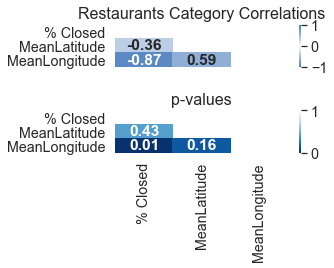

In [47]:
restaurants_pd = pd.read_csv('restaurants_pd.csv')
# visualization of Restaurants category correlations - for narrative purposes - no assigned Figure
df_corr = restaurants_pd[['pct_closed', 'latitude_mean', 'longitude_mean']]
tickrestaurants_pd = np.array(['% Closed','MeanLatitude', 'MeanLongitude'])
fig,ax = plt.subplots(figsize = (5, 4))
cmap = sns.diverging_palette(250, 250, sep = 25, as_cmap = True)

plt.subplot(2,1,1)
correlations = calculate_corr(df_corr).astype(float)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, mask = mask, annot = True, vmin = -1, vmax = 1, cmap = cmap, xticklabels = '', 
            yticklabels = tickrestaurants_pd, annot_kws = {"fontweight": 'bold'})
plt.title('Restaurants Category Correlations', fontsize=16)
plt.tight_layout()

plt.subplot(2,1,2)
pvalues = calculate_pvalues(df_corr).astype(float)
mask = np.zeros_like(pvalues)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pvalues, mask = mask, annot = True, vmin = 0, vmax = 1, cmap = "Blues_r", 
            xticklabels = tickrestaurants_pd, yticklabels = tickrestaurants_pd, annot_kws = {"fontweight": 'bold'})
plt.title('p-values', fontsize = 16)
plt.tight_layout()

In [48]:
# Use SQL SELECT/WHERE clause to filter among dummy variables for outdoor recreation businesses
outdoor = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE mountain_biking == 1 OR lakes == 1 OR golf == 1 OR hiking == 1 OR mini_golf ==1 OR amusement_parks==1 OR horseback_riding==1 OR parks==1 OR bike_rentals==1 OR hiking==1")


In [49]:
# Use SQL SELECT/WHERE clause to filter among dummy variables for indoor recreation businesses
indoor = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE escape_games==1 OR go_karts==1 OR axe_throwing==1 OR fitness==1 OR bowling==1")

In [50]:
outdoor.createOrReplaceTempView("outdoor")
indoor.createOrReplaceTempView("indoor")

In [51]:
# USE SQL SELECT/WHERE clause to calculate percentage of sub-category closed
outdoorrecpct = ((spark.sql("SELECT * FROM outdoor WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM outdoor WHERE is_open == 0").count())/outdoor.count())
indoorrecpct = ((spark.sql("SELECT * FROM indoor WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM indoor WHERE is_open == 0").count())/indoor.count())

In [52]:
# Create Pandas DataFrame of sub-category closure percentages for visualization: Table 2
table2 = pd.DataFrame()
table2['Table 2.'] = ['','']
table2['Sub-category'] = ['Non-Team Outdoor', 'Indoor/Group']
table2['% Closed'] = [round(outdoorrecpct*100, 1), round(indoorrecpct*100, 1)]
table2

,Table 2.,Sub-category,% Closed
0,,Non-Team Outdoor,0.0
1,,Indoor/Group,0.0


In [53]:
# Group restaurants category DataFrame by state and aggregate counts, means, and percentage closed
indoor_groupby_state_query = """
SELECT state, count(state) as indoor_activity_bus, ((count(state)-sum(is_open))+sum(temp_closed))/count(state) as pct_closed, mean(latitude) as latitude_mean, mean(longitude) as longitude_mean, emergency_to_home_days, emergency_from_mean, stay_from_mean, mean(Average_polarity) as polarity_mean, mean(Average_subjectivity) as subjectivity_mean, `Loan Count`, `Net Dollars`
FROM indoor
GROUP BY state, emergency_to_home_days, emergency_from_mean, stay_from_mean, `Loan Count`, `Net Dollars`
"""

In [54]:
indoor_groupby_state = spark.sql(indoor_groupby_state_query)

In [55]:
# collect sub-category data grouped by state into Pandas DataFrame for visualization
indoor_pd = indoor_groupby_state.toPandas()

In [56]:
# add state political leaning column
#indoor_pd['political'] = [-1, 1, -1, -1, 2, -2, -1]

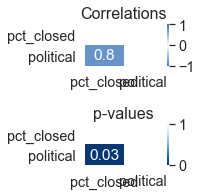

In [57]:
indoor_pd = pd.read_csv('indoor_pd.csv')
# visualization of Restaurants category correlations - for narrative purposes - no assigned Figure
df_corr = indoor_pd[['pct_closed', 'political']]
fig,ax = plt.subplots(figsize = (3, 3))
cmap = sns.diverging_palette(250, 250, sep = 25, as_cmap = True)

plt.subplot(2,1,1)
correlations = calculate_corr(df_corr).astype(float)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, mask = mask, annot = True, vmin = -1, vmax = 1, cmap = cmap)
plt.title('Correlations', fontsize = 16)

plt.subplot(2,1,2)
pvalues = calculate_pvalues(df_corr).astype(float)
mask = np.zeros_like(pvalues)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pvalues, mask = mask, annot = True, vmin = 0, vmax = 1, cmap = "Blues_r")
plt.title('p-values', fontsize = 16)

plt.tight_layout()
plt.show()

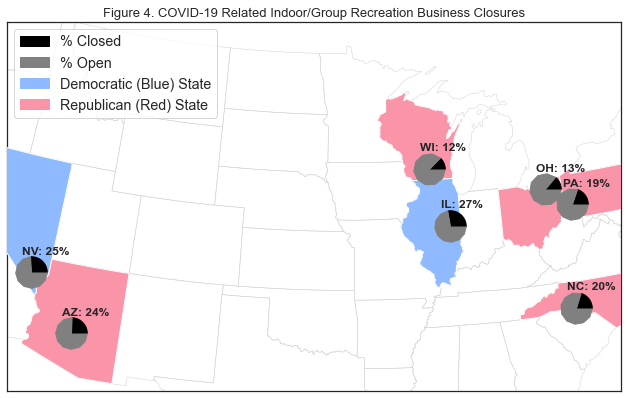

In [58]:
#Figure 4: COVID-19 Related Indoor/Group Recreation Business Closure
count = 0
point_dict = {}
for index, row in indoor_pd.iterrows():
    r1 = row['pct_closed']
    r2 = r1 + 1 - row['pct_closed']
  
    x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
    y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
    xy1 = np.column_stack([x, y])
    s1 = np.abs(xy1).max()
    x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
    y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
    xy2 = np.column_stack([x, y])
    s2 = np.abs(xy2).max()
   
    count+=1
   
    point_dict[count] = row['longitude_mean'], row['latitude_mean'], xy1, xy2, row['state'], int(row['pct_closed']*100)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(11, 8.5)
  
map = Basemap(llcrnrlon = -115, llcrnrlat = 30, urcrnrlon = -74,urcrnrlat = 49, projection='lcc',
              lat_1 = 33, lat_2 = 45, lon_0 = -95)
map.readshapefile('cb_2018_us_state_20m', 'states', linewidth = 0.5, color = '#d3d3d3')

state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])
    
seg = map.states[state_names.index('Nevada')]
seg2 = map.states[state_names.index('Arizona')]
seg3 = map.states[state_names.index('North Carolina')]
seg4 = map.states[state_names.index('Illinois')]
seg6 = map.states[state_names.index('Pennsylvania')]
poly = Polygon(map.states[28], facecolor = '#f994a9', zorder = 25) #Wisconsin
poly1 = Polygon(seg, facecolor = '#8fbaff', zorder = 25) #Nevada
poly2 = Polygon(seg2, facecolor = '#f994a9', zorder = 25) #Arizona
poly3 = Polygon(seg3, facecolor = '#f994a9', zorder = 25) #North Carolina
poly4 = Polygon(seg4, facecolor = '#8fbaff', zorder = 25) #Illinois
poly5 = Polygon(map.states[5], facecolor = '#f994a9', zorder = 25) #Ohio
poly6 = Polygon(seg6, facecolor = '#f994a9', zorder = 25) #Pennsylvania
ax.add_patch(poly)
ax.add_patch(poly1)
ax.add_patch(poly2)
ax.add_patch(poly3)
ax.add_patch(poly4)
ax.add_patch(poly5)
ax.add_patch(poly6)
for item in point_dict:
    a = map(point_dict[item][0], point_dict[item][1])
    plt.scatter(a[0], a[1], 1000, marker = (point_dict[item][2]), facecolor = 'black', zorder = 50)
    plt.scatter(a[0], a[1], 1000, marker = (point_dict[item][3]), facecolor = 'gray', zorder = 50)
    plt.text(a[0]-50000, a[1]+99999, str(point_dict[item][4])+": "+ str(int(point_dict[item][5]))+"%", fontsize = 12,
             fontweight = 'bold', zorder = 100)
   
black_patch = mpatches.Patch(color = 'black', label = "% Closed")
gray_patch = mpatches.Patch(color = 'gray', label = "% Open")
red_patch = mpatches.Patch(color = '#f994a9', label = "Republican (Red) State")
blue_patch = mpatches.Patch(color = '#8fbaff', label = "Democratic (Blue) State")
plt.legend(handles = [black_patch, gray_patch, blue_patch, red_patch])
plt.title('Figure 4. COVID-19 Related Indoor/Group Recreation Business Closures', fontsize = 13)  
plt.savefig('indoorrecreation.png', format = 'png')

In [59]:
# Use SQL SELECT/WHERE clause to filter among dummy variables
group_dine = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE fondue == 1 OR tapas==1 OR hot_pot==1 OR buffets==1")

In [60]:
home_dine = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE pizza==1 OR chinese==1 OR fast_food==1")

In [61]:
group_dine.createOrReplaceTempView("group_dine")
home_dine.createOrReplaceTempView("home_dine")

In [62]:
# Use SQL SELECT/WHERE clause to calculate percentage of sub-category closed
#grpdinepct = ((spark.sql("SELECT * FROM group_dine WHERE temp_closed == 1").count()+ \
#      spark.sql("SELECT * FROM group_dine WHERE is_open == 0").count())/group_dine.count())
#homedinepct = ((spark.sql("SELECT * FROM home_dine WHERE temp_closed == 1").count()+ \
#      spark.sql("SELECT * FROM home_dine WHERE is_open == 0").count())/home_dine.count())

In [63]:
# Create Pandas DataFrame of sub-category closure percentages for visualization: Table 1
#table1 = pd.DataFrame()
#table1['Table 1.'] = ['','']
#table1['Sub-category'] = ['Indoor Group Dining', 'Home Dining']
#table1['% Closed'] = [round(grpdinepct*100, 1), round(homedinepct*100, 1)]
#table1

In [64]:
# Group DataFrame by state and aggregate counts, means, and percentage closed
group_dine_groupby_state_query = """
SELECT state, count(state) as group_dine_bus, ((count(state)-sum(is_open))+sum(temp_closed))/count(state) as pct_closed, mean(latitude) as latitude_mean, mean(longitude) as longitude_mean, emergency_to_home_days, emergency_from_mean, stay_from_mean, mean(Average_polarity) as polarity_mean, mean(Average_subjectivity) as subjectivity_mean, `Loan Count`, `Net Dollars`
FROM group_dine
GROUP BY state, emergency_to_home_days, emergency_from_mean, stay_from_mean, `Loan Count`, `Net Dollars`
"""

In [65]:
group_dine_groupby_state = spark.sql(group_dine_groupby_state_query)

In [66]:
# collect sub-category data grouped by state into Pandas DataFrame for visualization
group_dine_pd = group_dine_groupby_state.toPandas()

In [67]:
# add state political leaning column
group_dine_pd['political'] = [-1, 1, -1, -1, 2, -2, -1]

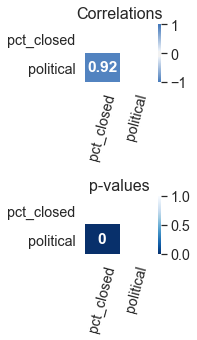

In [68]:
group_dine_pd = pd.read_csv('group_dine_pd.csv')
# visualization of group dining sub-category correlations - for narrative purposes - no assigned figure
df_corr = group_dine_pd[['pct_closed', 'political']]
fig,ax = plt.subplots(figsize=(3, 5))
cmap = sns.diverging_palette(250, 250, sep = 25, as_cmap = True)

plt.subplot(2,1,1)
correlations = calculate_corr(df_corr).astype(float)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, mask = mask, annot = True, vmin = -1, vmax = 1, cmap = cmap, 
            annot_kws = {"fontweight": 'bold'})
plt.title('Correlations', fontsize = 16)
plt.xticks(rotation = 75)

plt.subplot(2,1,2)
pvalues = calculate_pvalues(df_corr).astype(float)
mask = np.zeros_like(pvalues)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pvalues, mask = mask, annot = True, vmin = 0, vmax = 1, cmap = "Blues_r", 
            annot_kws = {"fontweight": 'bold'})
plt.title('p-values', fontsize = 16)
plt.xticks(rotation = 75)

plt.tight_layout()
plt.show()

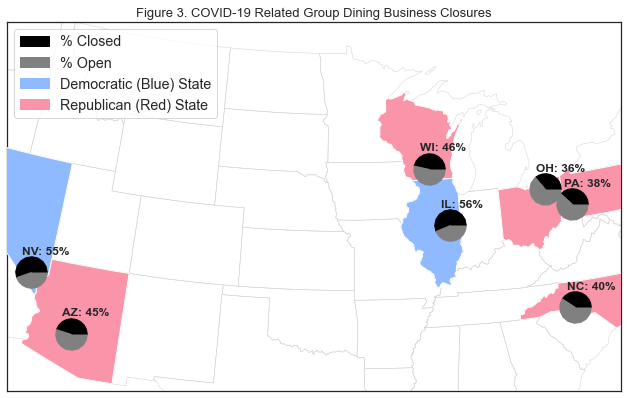

In [69]:
#Figure 3: COVID-19 Related Group Dining Business Closures
count = 0

point_dict = {}

for index, row in group_dine_pd.iterrows():

    r1 = row['pct_closed']
    r2 = r1 + 1 - row['pct_closed']
    
    x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
    y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
    xy1 = np.column_stack([x, y])
    s1 = np.abs(xy1).max()

    x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
    y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
    xy2 = np.column_stack([x, y])
    s2 = np.abs(xy2).max()
    
    count+=1
    
    point_dict[count] = row['longitude_mean'], row['latitude_mean'], xy1, xy2, row['state'], round(row['pct_closed']*100,1)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(11, 8.5)

   
map = Basemap(llcrnrlon = -115, llcrnrlat = 30, urcrnrlon = -74, urcrnrlat = 49,
        projection = 'lcc', lat_1 = 33, lat_2 = 45, lon_0 = -95)
map.readshapefile('cb_2018_us_state_20m', 'states', linewidth = 0.5, color = '#d3d3d3')

state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])

seg = map.states[state_names.index('Nevada')]
seg2 = map.states[state_names.index('Arizona')]
seg3 = map.states[state_names.index('North Carolina')]
seg4 = map.states[state_names.index('Illinois')]
seg6 = map.states[state_names.index('Pennsylvania')]

poly = Polygon(map.states[28], facecolor = '#f994a9', zorder = 25) #Wisconsin
poly1 = Polygon(seg, facecolor = '#8fbaff', zorder = 25) #Nevada
poly2 = Polygon(seg2, facecolor = '#f994a9', zorder = 25) #Arizona
poly3 = Polygon(seg3, facecolor = '#f994a9', zorder = 25) #North Carolina
poly4 = Polygon(seg4, facecolor = '#8fbaff', zorder = 25) #Illinois
poly5 = Polygon(map.states[5], facecolor = '#f994a9', zorder = 25) #Ohio
poly6 = Polygon(seg6, facecolor = '#f994a9', zorder = 25) #Pennsylvania

ax.add_patch(poly)
ax.add_patch(poly1)
ax.add_patch(poly2)
ax.add_patch(poly3)
ax.add_patch(poly4)
ax.add_patch(poly5)
ax.add_patch(poly6)

for item in point_dict:
    a = map(point_dict[item][0], point_dict[item][1])
    plt.scatter(a[0], a[1], 1000, marker = (point_dict[item][2]), facecolor = 'black', zorder = 50)
    plt.scatter(a[0], a[1], 1000, marker = (point_dict[item][3]), facecolor = 'gray', zorder = 50)
    plt.text(a[0]-50000, a[1]+99999, str(point_dict[item][4])+": "+ str(int(point_dict[item][5]))+"%", 
             fontsize = 12, fontweight = 'bold', zorder = 100)

black_patch = mpatches.Patch(color = 'black', label = "% Closed")
gray_patch = mpatches.Patch(color = 'gray', label = "% Open")
red_patch = mpatches.Patch(color = '#f994a9', label = "Republican (Red) State")
blue_patch = mpatches.Patch(color = '#8fbaff', label = "Democratic (Blue) State")
plt.legend(handles=[black_patch, gray_patch, blue_patch, red_patch])
plt.title('Figure 3. COVID-19 Related Group Dining Business Closures', fontsize = 13)
plt.savefig('groupdining.png', format = 'png')


In [70]:
# Use SQL SELECT/WHERE clause to filter among dummy variables to create sub-category dataframes
wholesale_stores = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE wholesale_stores == 1")
grocery = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE grocery==1")
drug_stores = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE drug_stores==1")
wholesale_stores.createOrReplaceTempView("wholesale_stores")
grocery.createOrReplaceTempView("grocery")
drug_stores.createOrReplaceTempView("drug_stores")

# Use SQL SELECT/WHERE clause to calculate percentage of sub-category closed
#wholesalepct = ((spark.sql("SELECT * FROM wholesale_stores WHERE temp_closed == 1").count()+ \
#      spark.sql("SELECT * FROM wholesale_stores WHERE is_open == 0").count())/wholesale_stores.count())
#grocerypct = ((spark.sql("SELECT * FROM grocery WHERE temp_closed == 1").count()+ \
#      spark.sql("SELECT * FROM grocery WHERE is_open == 0").count())/grocery.count())
#drugpct = ((spark.sql("SELECT * FROM drug_stores WHERE temp_closed == 1").count()+ \
#      spark.sql("SELECT * FROM drug_stores WHERE is_open == 0").count())/drug_stores.count())


In [71]:
# Create Pandas DataFrame of sub-category closure percentages for visualization: Table 3
#table3 = pd.DataFrame()
#table3['Table 3.'] = ['','','']
#table3['Sub-category'] = ['Wholesale Stores', 'Grocery Stores', 'Drug Stores']
#table3['% Closed'] = [round(wholesalepct*100, 1), round(grocerypct*100, 1), round(drugpct*100, 1)]
#table3

In [72]:
# Group sub-category by state and agrregate counts, means, and percentage closed
grocery_groupby_state_query = """
SELECT state, count(state) as grocery_bus, ((count(state)-sum(is_open))+sum(temp_closed))/count(state) as pct_closed, mean(latitude) as latitude_mean, mean(longitude) as longitude_mean, emergency_to_home_days, emergency_from_mean, stay_from_mean, mean(Average_polarity) as polarity_mean, mean(Average_subjectivity) as subjectivity_mean, `Loan Count`, `Net Dollars`
FROM grocery
GROUP BY state, emergency_to_home_days, emergency_from_mean, stay_from_mean, `Loan Count`, `Net Dollars`
"""
grocery_groupby_state = spark.sql(grocery_groupby_state_query)

# Collect data from grouped (by state) pySpark DataFrame into Pandas DataFrame for visualization
grocery_pd = grocery_groupby_state.toPandas()

# add state political leaning
#grocery_pd['political'] = [-1, 1, -1, -1, 2, -2, -1]
#grocery_pd

In [73]:
# subset master DataFrame to create Category DataFrames
nightlife = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE nightlife == 1")
beer_wine_spirits = \
spark.sql("SELECT * FROM bus_COVID_orders_sent WHERE beer_wine_spirits==1")
nightlife.createOrReplaceTempView("nightlife")
beer_wine_spirits.createOrReplaceTempView("beer_wine_spirits")

# use SQL SELECT statements to count closed businesses in each category, total businesses in each category to
# calculate percentage of businesses listed as Closed on Yelp for each category
nightlifepct = ((spark.sql("SELECT * FROM nightlife WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM nightlife WHERE is_open == 0").count())/nightlife.count())
liquorstorespct = ((spark.sql("SELECT * FROM beer_wine_spirits WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM beer_wine_spirits WHERE is_open == 0").count())/beer_wine_spirits.count())

In [74]:
# Create Pandas DataFrame of sub-category closure percentages for visualization: Table 4
table4 = pd.DataFrame()
table4['Table 4.'] = ['','']
table4['Sub-category'] = ['Nightlife', 'Liquor Stores']
table4['% Closed'] = [round(nightlifepct*100, 1), round(liquorstorespct*100, 1)]
table4

,Table 4.,Sub-category,% Closed
0,,Nightlife,0.0
1,,Liquor Stores,0.0


In [75]:
# Group sub-category DataFrame by state and aggregate counts, means, and percentage closed
nightlife_groupby_state_query = """
SELECT state, count(state) as nightlife_bus, ((count(state)-sum(is_open))+sum(temp_closed))/count(state) as pct_closed, mean(latitude) as latitude_mean, mean(longitude) as longitude_mean, emergency_to_home_days, emergency_from_mean, stay_from_mean, mean(Average_polarity) as polarity_mean, mean(Average_subjectivity) as subjectivity_mean, `Loan Count`, `Net Dollars`
FROM nightlife
GROUP BY state, emergency_to_home_days, emergency_from_mean, stay_from_mean, `Loan Count`, `Net Dollars`
"""
nightlife_groupby_state = spark.sql(nightlife_groupby_state_query)

# Collect data from grouped (by state) sub-category pySpark DataFrame into Pandas DataFrame for visualization
nightlife_pd = nightlife_groupby_state.toPandas()

# add state political leaning
#nightlife_pd['political'] = [-1, 1, -1, -1, 2, -2, -1]

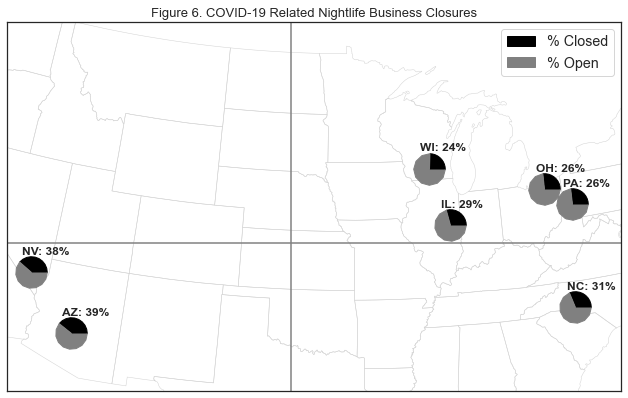

In [76]:
nightlife_pd = pd.read_csv('nightlife_pd.csv')
# Geographic visualization of nightlife closures - Figure 6
count = 0
point_dict = {}
for index, row in nightlife_pd.iterrows():

    r1 = row['pct_closed']
    r2 = r1 + 1 - row['pct_closed']
    
    x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
    y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
    xy1 = np.column_stack([x, y])
    s1 = np.abs(xy1).max()

    x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
    y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
    xy2 = np.column_stack([x, y])
    s2 = np.abs(xy2).max()
    
    count+=1
    
    point_dict[count] = row['longitude_mean'], row['latitude_mean'], xy1, xy2, row['state'], round(row['pct_closed']*100,1)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(11, 8.5)

   
map = Basemap(llcrnrlon = -115, llcrnrlat = 30, urcrnrlon = -74, urcrnrlat = 49,
        projection = 'lcc', lat_1 = 33, lat_2 = 45, lon_0 = -95)
map.readshapefile('cb_2018_us_state_20m', 'states', linewidth = 0.5, color = '#d3d3d3')

for item in point_dict:
    a = map(point_dict[item][0], point_dict[item][1])
    plt.scatter(a[0], a[1], 1000, marker = (point_dict[item][2]), facecolor = 'black', zorder = 50)
    plt.scatter(a[0], a[1], 1000, marker = (point_dict[item][3]), facecolor = 'gray', zorder = 50)
    plt.text(a[0]-50000, a[1]+99999, str(point_dict[item][4])+": "+ str(int(point_dict[item][5]))+"%", 
             fontsize = 12, fontweight = 'bold', zorder = 100)

black_patch = mpatches.Patch(color = 'black', label = "% Closed")
gray_patch = mpatches.Patch(color = 'gray', label = "% Open")
plt.legend(handles = [black_patch, gray_patch])

plt.axvline(1600000, color = 'gray')
plt.axhline(835000, color = 'gray')
plt.title('Figure 6. COVID-19 Related Nightlife Business Closures', fontsize = 13)
plt.savefig('nightlifelatlon.png', format = 'png')


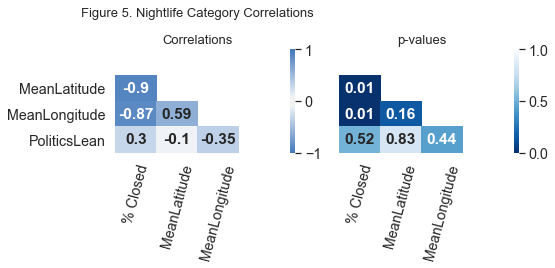

In [77]:
# Visualization of nightlife closures - Figure 5 - correlations
df_corr = nightlife_pd[['pct_closed', 'latitude_mean', 'longitude_mean', 'political']]
xticksnightlife_pd = np.array(['% Closed','MeanLatitude', 'MeanLongitude', '         '])
yticksnightlife_pd = np.array(['      ','MeanLatitude', 'MeanLongitude', 'PoliticsLean'])
fig,ax = plt.subplots(figsize=(8, 4))
cmap = sns.diverging_palette(250, 250, sep = 25, as_cmap = True)

plt.subplot(1, 2, 1)
correlations = calculate_corr(df_corr).astype(float)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, mask = mask, annot = True, vmin = -1, vmax = 1, cmap = cmap, 
            xticklabels = xticksnightlife_pd, yticklabels = yticksnightlife_pd, annot_kws = {"fontweight": 'bold'})
plt.title('Figure 5. Nightlife Category Correlations\n\nCorrelations', fontsize = 13)
plt.xticks(rotation = 75)
plt.tight_layout()

plt.subplot(1, 2, 2)
pvalues = calculate_pvalues(df_corr).astype(float)
mask = np.zeros_like(pvalues)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pvalues, mask = mask, annot = True, vmin = 0, vmax = 1, cmap = "Blues_r", 
            xticklabels = xticksnightlife_pd, yticklabels = '', annot_kws = {"fontweight": 'bold'})
plt.title('p-values', fontsize = 13)
plt.xticks(rotation = 75)
plt.tight_layout()

plt.savefig('nightlife.png', format = 'png')

In [78]:
# create new DataFrame with dummy variable columns for each metropolitan area so that businesses can be
# separated into urban or suburban/rural dummy variable categories. This is based on urban = city of named
# metropolitan area is equal to the name of the metropolitan area, while suburban/rural = city not equal to
# name of metropolitan area
rural_urban = \
bus_COVID_orders_sent.withColumn("Phoenix", \
                                    when(bus_COVID_orders_sent["city"] == \
                                         "Phoenix" , 1).otherwise(0))
rural_urban.createOrReplaceTempView("rural_urban")

In [79]:
rural_urban = \
rural_urban.withColumn("Las Vegas", \
                                    when(rural_urban["city"] == \
                                         "Las Vegas" , 1).otherwise(0))
rural_urban = \
rural_urban.withColumn("Pittsburgh", \
                                    when(rural_urban["city"] == \
                                         "Pittsburgh" , 1).otherwise(0))
rural_urban = \
rural_urban.withColumn("Charlotte", \
                                    when(rural_urban["city"] == \
                                         "Charlotte" , 1).otherwise(0))
rural_urban = \
rural_urban.withColumn("Urbana", \
                                    when(rural_urban["city"] == \
                                         "Urbana" , 1).otherwise(0))
rural_urban = \
rural_urban.withColumn("Madison", \
                                    when(rural_urban["city"] == \
                                         "Madison" , 1).otherwise(0))
rural_urban = \
rural_urban.withColumn("Cleveland", \
                                    when(rural_urban["city"] == \
                                         "Cleveland" , 1).otherwise(0))
rural_urban = \
rural_urban.withColumn("Champaign", \
                                    when(rural_urban["city"] == \
                                         "Champaign" , 1).otherwise(0))
rural_urban.createOrReplaceTempView("rural_urban")

In [80]:
# crate separate DataFrames with SQL SELECT/WHERE clauses from the dummy variables previously created
urban = \
spark.sql("SELECT * FROM rural_urban WHERE Phoenix==1 OR `Las Vegas`==1 OR Pittsburgh==1 OR Charlotte==1 OR Urbana==1 or Madison==1 OR Cleveland==1 OR Champaign==1")
rural = \
spark.sql("SELECT * FROM rural_urban WHERE Phoenix==0 AND `Las Vegas`==0 AND Pittsburgh==0 AND Charlotte==0 AND Urbana==0 AND Madison==0 AND Cleveland==0 AND Champaign==0")

In [81]:
# calculate percentage closed of urban and suburban/rural businesses using SQL SELECT/WHERE clauses
# and aggregate counts
urban.createOrReplaceTempView("urban")
rural.createOrReplaceTempView("rural")
print("% urban closed: " + str((spark.sql("SELECT * FROM urban WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM urban WHERE is_open == 0").count())/urban.count()*100))
print("% suburban/rural closed: "+str((spark.sql("SELECT * FROM rural WHERE temp_closed == 1").count()+ \
      spark.sql("SELECT * FROM rural WHERE is_open == 0").count())/rural.count()*100))


% urban closed: 17.142857142857142
% suburban/rural closed: 25.71428571428571


In [82]:
# Group urban business DataFrame by state and aggregate counts, means, and percentage closed
urban_groupby_state_query = """
SELECT state, count(state) as urban_bus, ((count(state)-sum(is_open))+sum(temp_closed))/count(state) as pct_closed, mean(latitude) as latitude_mean, mean(longitude) as longitude_mean, emergency_to_home_days, emergency_from_mean, stay_from_mean, mean(Average_polarity) as polarity_mean, mean(Average_subjectivity) as subjectivity_mean, `Loan Count`, `Net Dollars`
FROM urban
GROUP BY state, emergency_to_home_days, emergency_from_mean, stay_from_mean, `Loan Count`, `Net Dollars`
"""
urban_groupby_state = spark.sql(urban_groupby_state_query)

# collect grouped urban business data into Pandas DataFrame for visualization
urban_pd = urban_groupby_state.toPandas()

# add state political leaning column
#urban_pd['political'] = [-1, 1, -1, -1, 2, -2, -1]

In [83]:
# Group suburban/rural business DataFrame by state and aggregate counts, means, and percentage closed
rural_groupby_state_query = """
SELECT state, count(state) as rural_bus, ((count(state)-sum(is_open))+sum(temp_closed))/count(state) as pct_closed, mean(latitude) as latitude_mean, mean(longitude) as longitude_mean, emergency_to_home_days, emergency_from_mean, stay_from_mean, mean(Average_polarity) as polarity_mean, mean(Average_subjectivity) as subjectivity_mean, `Loan Count`, `Net Dollars`
FROM rural
GROUP BY state, emergency_to_home_days, emergency_from_mean, stay_from_mean, `Loan Count`, `Net Dollars`
"""
rural_groupby_state = spark.sql(rural_groupby_state_query)

# collect grouped suburban/rural business data into Pandas DataFrame for visualization
rural_pd = rural_groupby_state.toPandas()

# add state political leaning column
#rural_pd['political'] = [-1, 1, -1, -1, 2, -2, -1]

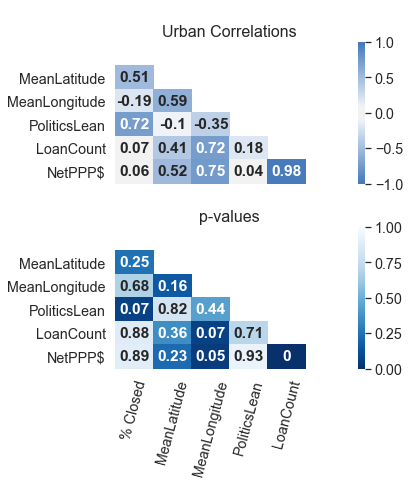

In [84]:
urban_pd = pd.read_csv('urban_pd.csv')
# Figure 8 (part 2) - correlation matrix for urban businesses
df_corr = urban_pd[['pct_closed', 'latitude_mean', 'longitude_mean', 'political', 'Loan Count', 'Net Dollars']]
ticksurbanrural = np.array(['% Closed','MeanLatitude', 'MeanLongitude', 'PoliticsLean', 'LoanCount', 'NetPPP$'])
ticksurbanruralyurban = np.array(['        ','MeanLatitude', 'MeanLongitude', 'PoliticsLean', 'LoanCount', 'NetPPP$'])
ticksurbanruralx = np.array(['% Closed','MeanLatitude', 'MeanLongitude', 'PoliticsLean', 'LoanCount', '     '])
ticksurbanruralyrural = np.array(['        ','MeanLatitude', 'MeanLongitude', 'PoliticsLean', 'LoanCount', 'NetPPP$'])
fig,ax = plt.subplots(figsize = (6, 7))
cmap = sns.diverging_palette(250, 250, sep = 25, as_cmap = True)

plt.subplot(2,1,1)
correlations = calculate_corr(df_corr).astype(float)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, mask = mask, annot = True, vmin = -1, vmax = 1, cmap = cmap, xticklabels = '',
            yticklabels = ticksurbanruralyurban, annot_kws = {"fontweight": 'bold'})
plt.title('     \nUrban Correlations', fontsize = 16)
plt.tight_layout()

plt.subplot(2,1,2)
pvalues = calculate_pvalues(df_corr).astype(float)
mask = np.zeros_like(pvalues)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pvalues, mask = mask, annot = True, vmin = 0, vmax = 1, cmap = "Blues_r", 
            xticklabels = ticksurbanruralx, yticklabels = ticksurbanruralyurban, annot_kws = {"fontweight": 'bold'})
plt.title('p-values', fontsize = 16)
plt.xticks(rotation = 75)
plt.tight_layout()

plt.savefig('urban.png', format = 'png')

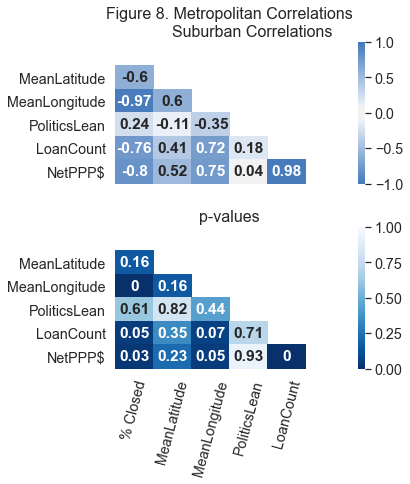

In [85]:
rural_pd = pd.read_csv('rural_pd.csv')
# Figure 8 (part 1) - correlation matrix for suburban/rural businesses
df_corr = rural_pd[['pct_closed', 'latitude_mean', 'longitude_mean', 'political', 'Loan Count', 'Net Dollars']]
fig,ax = plt.subplots(figsize = (6, 7))
cmap = sns.diverging_palette(250, 250, sep = 25, as_cmap = True)

plt.subplot(2,1,1)
correlations = calculate_corr(df_corr).astype(float)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, mask = mask, annot = True, vmin = -1, vmax = 1, cmap = cmap, xticklabels = '',
            yticklabels = ticksurbanruralyrural, annot_kws = {"fontweight": 'bold'})
plt.title('Figure 8. Metropolitan Correlations\n          Suburban Correlations', fontsize = 16)
plt.tight_layout()

plt.subplot(2,1,2)
pvalues = calculate_pvalues(df_corr).astype(float)
mask = np.zeros_like(pvalues)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pvalues, mask = mask, annot = True, vmin = 0, vmax = 1, cmap = "Blues_r", 
            xticklabels = ticksurbanruralx, yticklabels = ticksurbanruralyrural, annot_kws = {"fontweight": 'bold'})
plt.title('p-values', fontsize = 16)
plt.xticks(rotation = 75)
plt.tight_layout()

plt.savefig('rural.png', format = 'png')